### Library



In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
from bokeh.palettes import inferno, plasma
output_notebook()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

### Data

In [ ]:
df_06 = pd.read_csv('CARD_SUBWAY_MONTH_202106.csv', index_col = False)

In [ ]:
df_06.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20210601,3호선,신사,28955,30583,20210604
1,20210601,3호선,잠원,4780,4656,20210604
2,20210601,3호선,고속터미널,33986,32532,20210604
3,20210601,3호선,교대(법원.검찰청),14136,9362,20210604
4,20210601,3호선,남부터미널(예술의전당),27604,28821,20210604


## 6월 1~ 30일 승차 승객

In [ ]:
df_06_1line = df_06[df_06.노선명 == '1호선']

In [ ]:
df_06_1line.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
529,20210601,1호선,청량리(서울시립대입구),19471,19469,20210604
530,20210601,1호선,제기동,16708,16982,20210604
531,20210601,1호선,신설동,13865,13495,20210604
532,20210601,1호선,동대문,10842,10245,20210604
533,20210601,1호선,종로5가,22299,21965,20210604


In [ ]:
pd.unique(df_06_1line.역명)

array(['청량리(서울시립대입구)', '제기동', '신설동', '동대문', '종로5가', '종로3가', '종각', '시청',
       '동묘앞', '서울역'], dtype=object)

In [ ]:
def make_lines_df(df, name) : 
  tmp_df = df[df.역명 == name]
  return tmp_df

In [ ]:
def make_graph_lines(df) : 
  # 승차 승객수를 시각화
  p = figure(title = "Lines Passenger", x_axis_label = 'Day', y_axis_label = 'Passenger')
  stations = pd.unique(df.역명)
  colors = itertools.cycle(inferno(len(stations)))

  for st_name in stations : 
    tmp_df = make_lines_df(df, st_name)
    day_max = len(tmp_df.사용일자)
    p.line([i+1 for i in range(day_max)], tmp_df.승차총승객수,
           line_width = 2, legend_label = st_name, color = next(colors))
  
  p.legend.label_text_font_size = "8px"
  show(p)

In [ ]:
make_graph_lines(df_06_1line)

In [ ]:
tmp_df1 = df_06_1line[df_06_1line.역명 == '동묘앞']
tmp_df2 = df_06_1line[df_06_1line.역명 == '종각']
check_cycle = pd.concat([tmp_df1, tmp_df2])
make_graph_lines(check_cycle)

모든 역은 비슷한 계절성을 가지고 있으며, <br>
완만하게 보이는 것은 상대적인 승차 인원 수의 차이로 나타나는 착시이다. <br>
단, 동묘앞은 주말과 평일이 바뀌는 기이한 그래프를 나타냈다.

## 6월 1 ~ 30일 승하차 승객 비율

In [ ]:
def make_graph_passenger_rate(df) : 
  # 하차 / 승차 승객 시각화
  p = figure(title = "Get into and out of Train Rate", x_axis_label = 'Day', y_axis_label = '')
  stations = pd.unique(df.역명)
  colors = itertools.cycle(inferno(len(stations)))

  for st_name in stations : 
    tmp_df = make_lines_df(df, st_name)
    day_max = len(tmp_df.사용일자)
    passenger_rate = round(tmp_df.하차총승객수 / tmp_df.승차총승객수 * 100, 2)
    p.line([i+1 for i in range(day_max)], passenger_rate,
           line_width = 2, legend_label = st_name, color = next(colors))
  
  p.legend.label_text_font_size = "8px"
  show(p)

In [ ]:
make_graph_passenger_rate(df_06_1line)

In [ ]:
check_cycle = df_06_1line[df_06_1line.역명 == '서울역']
check_cycle = check_cycle.append(df_06_1line[df_06_1line.역명 == '동대문'])
make_graph_passenger_rate(check_cycle)

In [ ]:
from bokeh.models import ColumnDataSource

def make_graph_horizontal_stack_passenger(df) : 
  # 승하차 가로 그래프
  stations = list(pd.unique(df.역명))
  days_max = len(pd.unique(df.사용일자))
  days = list(pd.unique(df.사용일자))
  days = list(map(str, days))
  colors = itertools.cycle(inferno(len(days)))
  color_list1 = [next(colors) for _ in range(len(days))]
  colors = itertools.cycle(plasma(len(days)))
  color_list2 = [next(colors) for _ in range(len(days))]
  imports_val = [[] for i in range(days_max)]
  exports_val = [[] for i in range(days_max)]

  for st_name in stations : 
    tmp_df = make_lines_df(df, st_name)
    tmp_imports = list(tmp_df.승차총승객수)
    tmp_exports = list(tmp_df.하차총승객수)
    for tp_im, tp_ex, count in zip(tmp_imports, tmp_exports, range(days_max)) : 
      imports_val[count].append(tp_im)
      exports_val[count].append(-tp_ex)

  #source = ColumnDataSource(data = dict(stations = stations, counts = means, color = color_list))
  imports = {'stations' : stations}
  exports = {'stations' : stations}

  for im_val, ex_val, day_name in zip(imports_val, exports_val, days) :
    imports[day_name] = im_val
    exports[day_name] = ex_val
  
  

  p = figure(y_range = stations, title = "Horizontal_Stack_Passenger")
  p.hbar_stack(days, y = 'stations', height = 0.9, color = color_list1,
               source = ColumnDataSource(imports))#, legend_label = days)
  p.hbar_stack(days, y = 'stations', height = 0.9, color = color_list2,
               source = ColumnDataSource(exports))#, legend_label = days)
  p.xgrid.band_hatch_pattern = "/"
  p.xgrid.band_hatch_alpha = 0.6
  p.xgrid.band_hatch_color = "grey"
  p.xgrid.band_hatch_weight = 0.5
  p.xgrid.band_hatch_scale = 10
  show(p)

In [ ]:
make_graph_horizontal_stack_passenger(df_06_1line)

In [ ]:
from bokeh.sampledata.unemployment1948 import data
data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1948,4.0,4.7,4.5,4.0,3.4,3.9,3.9,3.6,3.4,2.9,3.3,3.6,3.8
1,1949,5.0,5.8,5.6,5.4,5.7,6.4,7.0,6.3,5.9,6.1,5.7,6.0,5.9
2,1950,7.6,7.9,7.1,6.0,5.3,5.6,5.3,4.1,4.0,3.3,3.8,3.9,5.3
3,1951,4.4,4.2,3.8,3.2,2.9,3.4,3.3,2.9,3.0,2.8,3.2,2.9,3.3
4,1952,3.7,3.8,3.3,3.0,2.9,3.2,3.3,3.1,2.7,2.4,2.5,2.5,3.0


In [ ]:
data['Year'] = data['Year'].astype(str)
data = data.set_index('Year')
data.drop('Annual', axis=1, inplace=True)
data.columns.name = 'Month'

years = list(data.index)
months = list(data.columns)

# reshape to 1D array or rates with a month and year for each row.
df = pd.DataFrame(data.stack(), columns=['rate']).reset_index()
df

,Year,Month,rate
0,1948,Jan,4.0
1,1948,Feb,4.7
2,1948,Mar,4.5
3,1948,Apr,4.0
4,1948,May,3.4
...,...,...,...
823,2016,Aug,5.0
824,2016,Sep,4.8
825,2016,Oct,4.7
826,2016,Nov,4.4


In [ ]:
df_06_1line.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
529,20210601,1호선,청량리(서울시립대입구),19471,19469,20210604
530,20210601,1호선,제기동,16708,16982,20210604
531,20210601,1호선,신설동,13865,13495,20210604
532,20210601,1호선,동대문,10842,10245,20210604
533,20210601,1호선,종로5가,22299,21965,20210604


In [ ]:
hover_data = pd.DataFrame.copy(df_06_1line)
hover_data['rate'] = round(hover_data['하차총승객수'] / hover_data['승차총승객수'],2) * 100
hover_data.pop('승차총승객수')
hover_data.pop('하차총승객수')
hover_data.pop('등록일자')
hover_data.pop('노선명')
hover_data.rename(columns = {"사용일자" : "Year"}, inplace = True)
hover_data.rename(columns = {"역명" : "Month"}, inplace = True)
hover_data.index = [i for i in range(300)]
hover_data

,Year,Month,rate
0,20210601,청량리(서울시립대입구),100.0
1,20210601,제기동,102.0
2,20210601,신설동,97.0
3,20210601,동대문,94.0
4,20210601,종로5가,99.0
...,...,...,...
295,20210630,종로3가,90.0
296,20210630,종각,98.0
297,20210630,시청,102.0
298,20210630,동묘앞,105.0


In [ ]:
def make_time_series_df(df) : 
  station_names = list(pd.unique(df.역명))
  df['승하차비율'] = round(df['하차총승객수'] / df['승차총승객수'], 2) * 100
  times = list(pd.unique(df.사용일자))
  tmp = pd.DataFrame({
      '사용일자' : times,
      '청량리(서울시립대입구)' : list(df[df.역명 == station_names[0]].승하차비율),
      '제기동' : list(df[df.역명 == station_names[1]].승하차비율),
      '신설동' : list(df[df.역명 == station_names[2]].승하차비율),
      '동대문' : list(df[df.역명 == station_names[3]].승하차비율),
      '종로5가' : list(df[df.역명 == station_names[4]].승하차비율),
      '종로3가' : list(df[df.역명 == station_names[5]].승하차비율),
      '종각' : list(df[df.역명 == station_names[6]].승하차비율),
      '시청' : list(df[df.역명 == station_names[7]].승하차비율),
      '동묘앞' : list(df[df.역명 == station_names[8]].승하차비율),
      '서울역' : list(df[df.역명 == station_names[9]].승하차비율),
  })
  return tmp

In [ ]:
hover_data = make_time_series_df(df_06_1line)
hover_data.head()

,사용일자,청량리(서울시립대입구),제기동,신설동,동대문,종로5가,종로3가,종각,시청,동묘앞,서울역
0,20210601,100.0,102.0,97.0,94.0,99.0,91.0,99.0,102.0,104.0,94.0
1,20210602,100.0,102.0,97.0,94.0,99.0,91.0,97.0,103.0,105.0,94.0
2,20210603,100.0,102.0,99.0,94.0,96.0,94.0,95.0,101.0,106.0,94.0
3,20210604,102.0,107.0,100.0,98.0,107.0,91.0,102.0,110.0,107.0,95.0
4,20210605,101.0,103.0,93.0,93.0,100.0,93.0,94.0,110.0,104.0,100.0


In [ ]:
from math import pi
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter

def make_graph_hover_map(data) : 
  data['사용일자'] = data['사용일자'].astype(str)
  data = data.set_index('사용일자')
  data.columns.name = '역명'
  days = list(data.index)
  station_names = list(data.columns)
  df = pd.DataFrame(data.stack(), columns=['rate']).reset_index()

  colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
  mapper = LinearColorMapper(palette=colors, low=df.rate.min(), high=df.rate.max())
  TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

  p = figure(title="Train Ratio of getting on and off ({0} - {1})".format(days[0], days[-1]),
           x_range = days, y_range=list(reversed(station_names)),
           x_axis_location="above", width=900, height=400,
           tools=TOOLS, toolbar_location='below',
           tooltips=[('date', '@역명 @사용일자'), ('rate', '@rate%')])
  
  p.grid.grid_line_color = None
  p.axis.axis_line_color = None
  p.axis.major_tick_line_color = None
  p.axis.major_label_text_font_size = "7px"
  p.axis.major_label_standoff = 0
  p.xaxis.major_label_orientation = pi / 3

  p.rect(x="사용일자", y="역명", width=1, height=1,
       source=df,
       fill_color={'field': 'rate', 'transform': mapper},
       line_color=None)

  color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="7px",
                      ticker=BasicTicker(desired_num_ticks=len(colors)),
                      formatter=PrintfTickFormatter(format="%d%%"),
                      label_standoff=6, border_line_color=None)
  p.add_layout(color_bar, 'right')

  show(p)

In [ ]:
make_graph_hover_map(hover_data)

전체적으로 1호선은 다른 호선에 비해 그래프들이 비슷한 모양을 띄지 않는 것이 특징

## 6월 평균 승차 승객

In [ ]:
from bokeh.models import ColumnDataSource

def make_graph_mean_passenger(df) : 
  # 승차 평균 승차 승객
  stations = list(pd.unique(df.역명))
  colors = itertools.cycle(inferno(len(stations)))
  color_list = [next(colors) for _ in range(len(stations))]
  means = []

  for st_name in stations : 
    tmp_df = make_lines_df(df, st_name)
    mean_val = np.mean(tmp_df.승차총승객수)
    means.append(mean_val)
    
  source = ColumnDataSource(data = dict(stations = stations, counts = means, color = color_list))

  p = figure(title = "Lines Passenger", x_range = stations, toolbar_location = None)
  p.vbar(x = 'stations', top = 'counts', width = 0.9, color = 'color', legend_field = 'stations', source = source)
  p.xgrid.grid_line_color = None
  p.xaxis.visible = False
  p.legend.label_text_font_size = "8px"
  p.legend.location = 'top_right'
  show(p)

In [ ]:
make_graph_mean_passenger(df_06_1line)

## 역간 거리 및 소요시간 분포

In [ ]:
#df_dis_time = pd.read_csv('distance_time.csv', encoding = 'utf-8')
# 에러로 csv가 읽히지 않음 (invalid start byte)
names_1line = ['서울역', '시청', '종각', '종로3가', '종로5가', '동대문', '동묘앞',
         '신설동', '제기동', '청량리']
times_1line = [0, 2, 3, 1, 2, 2, 1, 2, 2, 2]
distance_1line = [0, 1.1, 1, 0.8, 0.9, 0.8, 0.6, 0.7, 0.9, 1]
cummulated_1line = [0, 1.1, 2.1, 2.9, 3.8, 4.6, 5.2, 5.9, 6.8, 7.8]

df_distime_1line = pd.DataFrame({'역명' : names_1line,
                                 '시간' : times_1line,
                                 '거리' : distance_1line,
                                 '누적거리' : cummulated_1line})
df_distime_1line

,역명,시간,거리,누적거리
0,서울역,0,0.0,0.0
1,시청,2,1.1,1.1
2,종각,3,1.0,2.1
3,종로3가,1,0.8,2.9
4,종로5가,2,0.9,3.8
5,동대문,2,0.8,4.6
6,동묘앞,1,0.6,5.2
7,신설동,2,0.7,5.9
8,제기동,2,0.9,6.8
9,청량리,2,1.0,7.8


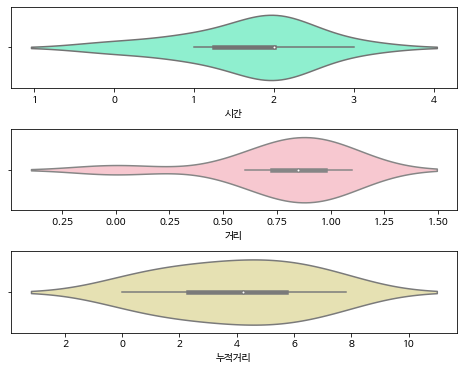

In [ ]:
import seaborn

fig, ax = plt.subplots(3, 1, figsize = (8, 6))
sns.violinplot(x = "시간", data = df_distime_1line, ax = ax[0], color = "aquamarine")
sns.violinplot(x = "거리", data = df_distime_1line, ax = ax[1], color = "pink")
sns.violinplot(x = "누적거리", data = df_distime_1line, ax = ax[2], color = "palegoldenrod")
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
from bokeh.sampledata.unemployment1948 import data
data

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1948,4.0,4.7,4.5,4.0,3.4,3.9,3.9,3.6,3.4,2.9,3.3,3.6,3.8
1,1949,5.0,5.8,5.6,5.4,5.7,6.4,7.0,6.3,5.9,6.1,5.7,6.0,5.9
2,1950,7.6,7.9,7.1,6.0,5.3,5.6,5.3,4.1,4.0,3.3,3.8,3.9,5.3
3,1951,4.4,4.2,3.8,3.2,2.9,3.4,3.3,2.9,3.0,2.8,3.2,2.9,3.3
4,1952,3.7,3.8,3.3,3.0,2.9,3.2,3.3,3.1,2.7,2.4,2.5,2.5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2012,8.8,8.7,8.4,7.7,7.9,8.4,8.6,8.2,7.6,7.5,7.4,7.6,8.1
65,2013,8.5,8.1,7.6,7.1,7.3,7.8,7.7,7.3,7.0,7.0,6.6,6.5,7.4
66,2014,7.0,7.0,6.8,5.9,6.1,6.3,6.5,6.3,5.7,5.5,5.5,5.4,6.2
67,2015,6.1,5.8,5.6,5.1,5.3,5.5,5.6,5.2,4.9,4.8,4.8,4.8,5.3


## 지하철 운용 정보

In [ ]:
names = ['1호선', '2호선 소계', '2호선 순환', '2호선 지선1', '2호선 지선2',
         '3호선', '4호선', '5호선', '6호선', '7호선', '8호선', '9호선1', '9호선2', '9호선3', '우이신설']
distance = [8, 60.2, 48.8, 5.4, 6, 38.2, 31.7, 56.9, 36.4, 57.1, 17.7, 27, 4.5, 9.1, 11] #km
stations = [10, 50, 43, 4, 3, 34, 26, 53, 39, 51, 17, 25, 5, 8, 13]
running_on_normal = [86, 954, 524, 218, 212, 272, 307, 438, 330, 420, 282, 354, 85, 0, 516]
year_passenger = [115584, 577744, 565232, 4221, 8291, 235105, 222536, 258551, 148148, 289974, 86820, 131231, 21542, 18861, 21121] # 천명
day_passenger = [316, 1579, 1545, 11, 23, 642, 608, 718, 405, 792, 237, 359, 59, 52, 58] # 천명

df_train_report = pd.DataFrame({'노선' : names,
                                '영업거리' : distance,
                                '역수' : stations,
                                '평일운행회수' : running_on_normal,
                                '연간총수송인원' : year_passenger,
                                '1일평균수송인원' : day_passenger})
df_train_report

,노선,영업거리,역수,평일운행회수,연간총수송인원,1일평균수송인원
0,1호선,8.0,10,86,115584,316
1,2호선 소계,60.2,50,954,577744,1579
2,2호선 순환,48.8,43,524,565232,1545
3,2호선 지선1,5.4,4,218,4221,11
4,2호선 지선2,6.0,3,212,8291,23
5,3호선,38.2,34,272,235105,642
6,4호선,31.7,26,307,222536,608
7,5호선,56.9,53,438,258551,718
8,6호선,36.4,39,330,148148,405
9,7호선,57.1,51,420,289974,792


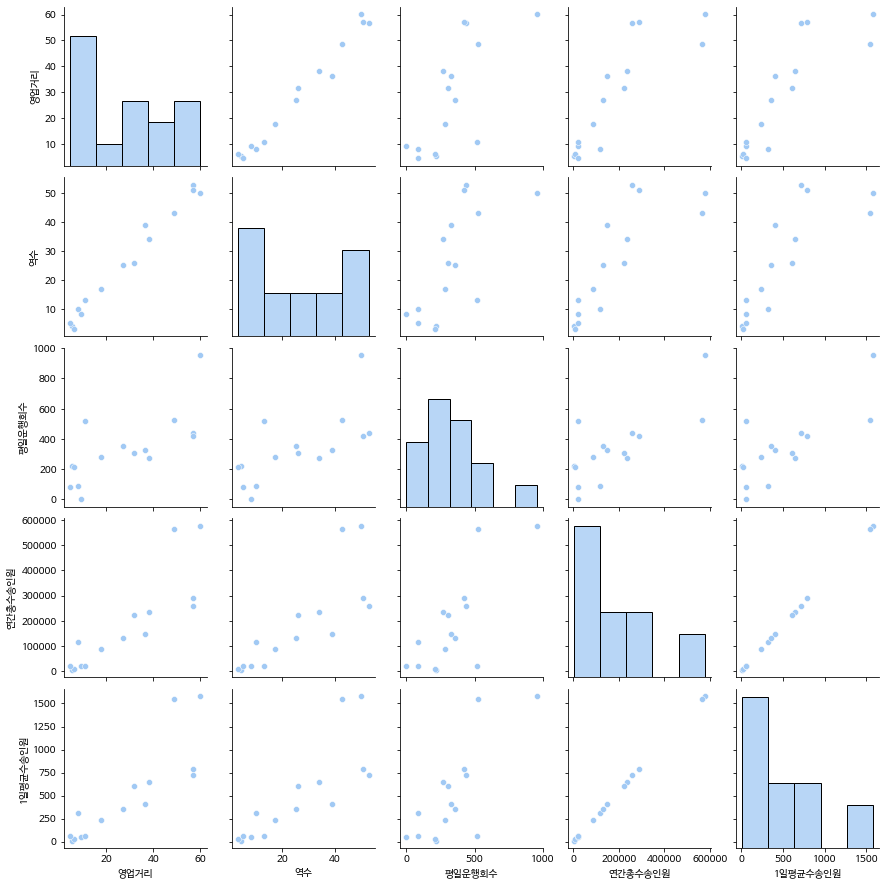

In [ ]:
sns.pairplot(df_train_report) #hue = '노선', palette = 'pastel')
plt.show()

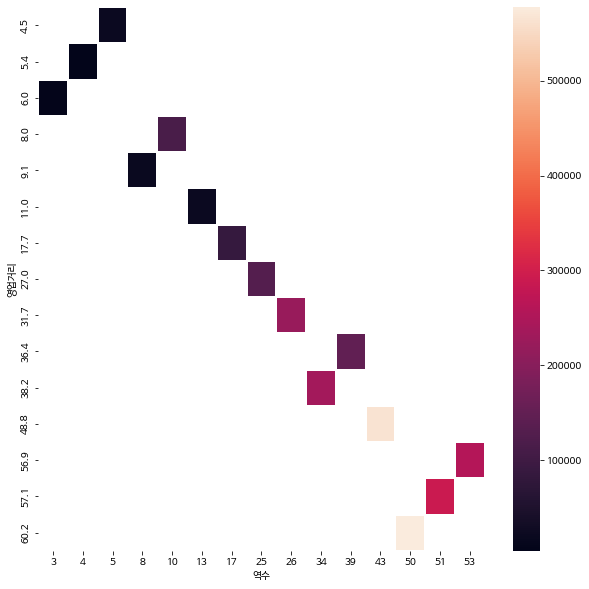

In [ ]:
pivot_data = df_train_report.pivot("영업거리", "역수", "연간총수송인원")
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(pivot_data, linewidths = 1)
plt.show()

## 지하철 Traffic 정보 2019



In [ ]:
df_traffic = pd.read_csv('train_traffic_report.txt', sep = '\t')
df_traffic.pop('기간')
df_traffic.pop('구분')
df_traffic['1단계'] = 145 # 87(145)
df_traffic['2단계'] = 58.3 # 20.7(58.3)
df_traffic['3단계'] = 14.5 # 7.5(14.5)
df_traffic # 단위 %

,평균,1호선,2호선,3호선,4호선,5호선,6호선,7호선,8호선,1단계,2단계,3단계,우이신설도시철도
0,134,106,173,144,162,107,106,146,131,145,58.3,14.5,161


In [ ]:
def make_graph_traffic(df) : 
  # 혼잡도 % 막대그래프
  stations = list(df.columns.values)
  colors = itertools.cycle(inferno(len(stations)))
  color_list = [next(colors) for _ in range(len(stations))]
  values = df.values[0]
    
  source = ColumnDataSource(data = dict(stations = stations, counts = values, color = color_list))

  p = figure(title = "Traffic Information (%) 2019", x_range = stations, toolbar_location = None)
  p.vbar(x = 'stations', top = 'counts', width = 0.9, color = 'color', legend_field = 'stations', source = source)
  p.xgrid.grid_line_color = None
  p.xaxis.visible = False
  p.legend.label_text_font_size = "8px"
  p.legend.orientation = 'horizontal'
  show(p)

In [ ]:
make_graph_traffic(df_traffic)

## 서울시 출퇴근 교통 이용 현황 2020

In [ ]:
df_public = pd.read_csv('public_transportation.txt', sep = '\t')
df_public.head(10)

,기간,대분류,분류,도보,자전거,자전거+기타교통수단,오토바이,버스,지하철(철도),버스+지하철,택시,승용차,승용차+버스,승용차+지하철,기타
0,2020,서울시,서울시,18.2,2.5,0.3,0.9,23.3,14.3,21.2,0.1,16.5,0.9,1.5,0.3
1,2020,성별,남자,14.0,2.8,0.4,1.3,19.7,14.6,20.7,0.1,23.1,1.0,1.9,0.3
2,2020,성별,여자,23.7,2.0,0.3,0.2,28.1,13.8,21.7,0.1,8.0,0.7,1.1,0.3
3,2020,연령별,10대,48.3,4.9,0.8,-,34.6,2.0,8.8,-,0.3,0.0,0.2,-
4,2020,연령별,20대,13.6,1.5,0.3,0.7,26.1,18.1,34.2,0.1,3.8,0.5,0.7,0.4
5,2020,연령별,30대,9.9,2.9,0.3,0.5,20.6,19.5,24.9,0.2,17.7,1.0,2.1,0.3
6,2020,연령별,40대,12.7,2.5,0.4,0.5,18.3,17.0,20.1,0.2,23.8,1.6,2.3,0.5
7,2020,연령별,50대,17.3,2.0,0.3,1,20.4,11.8,16.8,0.2,26.8,1.1,2.2,0.2
8,2020,연령별,60대 이상,29.5,2.7,0.1,2.2,27.9,7.3,10.9,0.1,18.2,0.5,0.6,0.1
9,2020,학력별,중졸 이하,50.7,2.8,0.3,2.6,24.6,4.2,8.2,0.2,5.9,0.1,0.2,0.1


In [ ]:
from math import pi
from bokeh.palettes import Category20c
from bokeh.transform import cumsum

def make_graph_pie(df, sept) : 
  df2 = df[df.대분류 == sept]
  values = list(map(float, df_public.iloc[0][3:].values))
  col_names = df.columns.values[3:]
  data = pd.DataFrame({
      'Transportation' : col_names,
      'value' : values
  })
  
  data['angle'] = data['value']/100 * 2 * pi
  data['color'] = Category20c[len(col_names)]
  p = figure(height = 350, title = "Transportation Pie Chart (2020)", toolbar_location = None,
             tools = "hover", tooltips = "@Transportation: @value", x_range = (-0.5, 1.0))
  p.wedge(x = 0, y = 1, radius = 0.4,
          start_angle = cumsum('angle', include_zero = True), end_angle = cumsum('angle'),
          line_color = 'white', fill_color = 'color', legend_field = 'Transportation', source = data)   
  p.axis.axis_label = None
  p.axis.visible = False
  p.grid.grid_line_color = None
  show(p)

In [ ]:
make_graph_pie(df_public, '서울시')

## 각 호선 위치

In [ ]:
df_map = pd.read_csv('station_coordinate.csv', encoding='utf-8')
df_map.head()

,line,name,code,lat,lng
0,01호선,녹양,1908.0,37.759380,127.042292
1,01호선,남영,1002.0,37.541021,126.971300
2,01호선,용산,1003.0,37.529849,126.964561
3,01호선,노량진,1004.0,37.514219,126.942454
4,01호선,대방,1005.0,37.513342,126.926382


In [ ]:
df_map[df_map.line == "수인선"].head()

,line,name,code,lat,lng
604,수인선,오이도,1800.0,37.362357,126.738714
605,수인선,달월,1878.0,37.379681,126.745177
606,수인선,월곶,1879.0,37.391769,126.742699
607,수인선,소래포구,1880.0,37.400950,126.733522
608,수인선,인천논현,1881.0,37.400614,126.722478


In [ ]:
change_value_dict = {'수인선' : '수인분당선', '분당선' : '수인분당선'}
df_map = df_map.replace({'line' : change_value_dict})

In [ ]:
df_map[df_map.line == "수인분당선"].head()

,line,name,code,lat,lng
555,수인분당선,선릉,1023.0,37.504503,127.049008
556,수인분당선,한티,1024.0,37.496237,127.052873
557,수인분당선,도곡,1025.0,37.490858,127.055381
558,수인분당선,구룡,1026.0,37.486839,127.058856
559,수인분당선,개포동,1027.0,37.489116,127.066140


In [ ]:
color_list_train = ["#003399", "#37b24d", "#fa5f2c", "#3172d3", "#893bb6", "#9a4e0f", "#606d00", "#e71e6e",
              "#bf9f1e", "#2673f2", "#7dc4a5", "#26a97f", "#70b7e5", "#96710a", "#edb217", "#8bc53f",
              "#a9022c", "#80ce79", "#c6bf00", "#ff8c00", "#ffb950", "#2673f2"]

In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(df_map, lat="lat", lon = "lng", hover_name = "name", hover_data = ["line"], color = "line",
                        color_discrete_sequence = color_list_train, zoom = 10, height = 400,
                        animation_frame = "line") # px.colors.sequential.Plasma_r
fig.update_layout(mapbox_style = "carto-positron")
fig.update_layout(margin = {"r":0, "t":0, "l":0, "b":0})
fig.show()

## 6월 지하철 사용자 변화 지도

In [ ]:
df_map_test = pd.DataFrame.copy(df_map)

In [ ]:
df_map_test

,line,name,code,lat,lng
0,01호선,녹양,1908.0,37.759380,127.042292
71,01호선,도화,1823.0,37.466070,126.668672
70,01호선,동암,1808.0,37.471408,126.702896
69,01호선,진위,1720.0,37.109447,127.062278
68,01호선,오산,1719.0,37.145885,127.066720
...,...,...,...,...,...
702,인천선,귤현,3111.0,37.566379,126.742654
701,인천선,계양,3110.0,37.571462,126.735637
728,인천선,국제업무지구,3138.0,37.399907,126.630347
714,인천선,인천시청,3124.0,37.457405,126.702221


In [ ]:
df_06_test = pd.DataFrame.copy(df_06)
df_06_test.pop('등록일자')
df_06_test.pop('노선명')
df_06_test.pop('하차총승객수')
df_06_test.rename(columns = {"역명" : "name"}, inplace = True)
df_test_join = pd.merge(left = df_map_test, right = df_06_test, how = 'inner', on = "name")

In [ ]:
df_test_join

,line,name,code,lat,lng,사용일자,승차총승객수
0,01호선,녹양,1908.0,37.759380,127.042292,20210601,4522
1,01호선,녹양,1908.0,37.759380,127.042292,20210602,4711
2,01호선,녹양,1908.0,37.759380,127.042292,20210603,4542
3,01호선,녹양,1908.0,37.759380,127.042292,20210604,4934
4,01호선,녹양,1908.0,37.759380,127.042292,20210605,3644
...,...,...,...,...,...,...,...
20279,우이신설경전철,삼양,4706.0,37.627165,127.018152,20210626,1466
20280,우이신설경전철,삼양,4706.0,37.627165,127.018152,20210627,1126
20281,우이신설경전철,삼양,4706.0,37.627165,127.018152,20210628,2070
20282,우이신설경전철,삼양,4706.0,37.627165,127.018152,20210629,1924


In [ ]:
df_test_join = df_test_join.sort_values(by = ['line'])

In [ ]:
df_test_join

,line,name,code,lat,lng,사용일자,승차총승객수
0,01호선,녹양,1908.0,37.759380,127.042292,20210601,4522
1,01호선,녹양,1908.0,37.759380,127.042292,20210602,4711
2,01호선,녹양,1908.0,37.759380,127.042292,20210603,4542
3,01호선,녹양,1908.0,37.759380,127.042292,20210604,4934
4,01호선,녹양,1908.0,37.759380,127.042292,20210605,3644
...,...,...,...,...,...,...,...
20279,우이신설경전철,북한산우이,4701.0,37.663146,127.012789,20210626,2789
20280,우이신설경전철,북한산우이,4701.0,37.663146,127.012789,20210627,3279
20281,우이신설경전철,북한산우이,4701.0,37.663146,127.012789,20210628,2519
20282,우이신설경전철,북한산우이,4701.0,37.663146,127.012789,20210629,2626


In [ ]:
df_test_join = df_test_join.sort_values(['line', '사용일자'], ascending = [True, True])

In [ ]:
color_list_sort = ["#003399", "#37b24d", "#fa5f2c", "#3172d3", "#893bb6", "#9a4e0f", "#606d00", "#e71e6e",
              "#bf9f1e", "#2673f2", "#7dc4a5", "#26a97f", "#70b7e5", "#96710a", "#8bc53f", "#edb217",
              "#a9022c", "#80ce79", "#c6bf00", "#ff8c00", "#ffb950", "#2673f2"]

In [ ]:
fig = px.scatter_mapbox(df_test_join, lat="lat", lon = "lng", hover_name = "name", hover_data = ["line"], color = "line",
                        color_discrete_sequence = color_list_sort, zoom = 10, height = 400, size = "승차총승객수",
                        animation_frame = "사용일자") # px.colors.sequential.Plasma_r
fig.update_layout(mapbox_style = "carto-positron")
fig.update_layout(margin = {"r":0, "t":0, "l":0, "b":0})
fig.show()

## 기타

In [ ]:
df_06.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20210601,3호선,신사,28955,30583,20210604
1,20210601,3호선,잠원,4780,4656,20210604
2,20210601,3호선,고속터미널,33986,32532,20210604
3,20210601,3호선,교대(법원.검찰청),14136,9362,20210604
4,20210601,3호선,남부터미널(예술의전당),27604,28821,20210604


In [ ]:
from bokeh.layouts import gridplot
from bokeh.models import BoxSelectTool, LassoSelectTool
from bokeh.plotting import curdoc, figure

x1 = np.random.normal(loc=5.0, size=400) * 100
y1 = np.random.normal(loc=10.0, size=400) * 10

x2 = np.random.normal(loc=5.0, size=800) * 50
y2 = np.random.normal(loc=5.0, size=800) * 10

x3 = np.random.normal(loc=55.0, size=200) * 10
y3 = np.random.normal(loc=4.0, size=200) * 10

x = np.concatenate((x1, x2, x3))
y = np.concatenate((y1, y2, y3))

TOOLS="pan,wheel_zoom,box_select,lasso_select,reset"

# create the scatter plot
p = figure(tools=TOOLS, width=600, height=600, min_border=10, min_border_left=50,
           toolbar_location="above", x_axis_location=None, y_axis_location=None,
           title="Linked Histograms")
p.background_fill_color = "#fafafa"
p.select(BoxSelectTool).select_every_mousemove = False
p.select(LassoSelectTool).select_every_mousemove = False

r = p.scatter(df_06.승차총승객수, df_06.하차총승객수, size = 3, color = "#3A5785", alpha = 0.6)

# create the horizontal histogram
hhist, hedges = np.histogram(df_06.승차총승객수, bins = 20)
hzeros = np.zeros(len(hedges)-1)
hmax = max(hhist)*1.1

LINE_ARGS = dict(color="#3A5785", line_color=None)

ph = figure(toolbar_location=None, width=p.width, height=200, x_range=p.x_range,
            y_range=(-hmax, hmax), min_border=10, min_border_left=50, y_axis_location="right")
ph.xgrid.grid_line_color = None
ph.yaxis.major_label_orientation = np.pi/4
ph.background_fill_color = "#fafafa"

ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hhist, color="white", line_color="#3A5785")
hh1 = ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hzeros, alpha=0.5, **LINE_ARGS)
hh2 = ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hzeros, alpha=0.1, **LINE_ARGS)

# create the vertical histogram
vhist, vedges = np.histogram(df_06.하차총승객수, bins=20)
vzeros = np.zeros(len(vedges)-1)
vmax = max(vhist)*1.1

pv = figure(toolbar_location=None, width=200, height=p.height, x_range=(-vmax, vmax),
            y_range=p.y_range, min_border=10, y_axis_location="right")
pv.ygrid.grid_line_color = None
pv.xaxis.major_label_orientation = np.pi/4
pv.background_fill_color = "#fafafa"

pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vhist, color="white", line_color="#3A5785")
vh1 = pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vzeros, alpha=0.5, **LINE_ARGS)
vh2 = pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vzeros, alpha=0.1, **LINE_ARGS)

layout = gridplot([[p, pv], [ph, None]], merge_tools=False)

curdoc().add_root(layout)
curdoc().title = "Selection Histogram"

def update(attr, old, new):
    inds = new
    if len(inds) == 0 or len(inds) == len(x):
        hhist1, hhist2 = hzeros, hzeros
        vhist1, vhist2 = vzeros, vzeros
    else:
        neg_inds = np.ones_like(x, dtype=np.bool)
        neg_inds[inds] = False
        hhist1, _ = np.histogram(x[inds], bins=hedges)
        vhist1, _ = np.histogram(y[inds], bins=vedges)
        hhist2, _ = np.histogram(x[neg_inds], bins=hedges)
        vhist2, _ = np.histogram(y[neg_inds], bins=vedges)

    hh1.data_source.data["top"]   =  hhist1
    hh2.data_source.data["top"]   = -hhist2
    vh1.data_source.data["right"] =  vhist1
    vh2.data_source.data["right"] = -vhist2

r.data_source.selected.on_change('indices', update)
show(p)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html

